# Import libraries

In [1]:
import os
import json
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Helper functions 

The process below will generate segmentation masks based on the annotations that came along with the dataset. These annotations highlight the location of the tumour regions.

In [2]:
def load_annotations(annotation_file):
    with open(annotation_file, 'r') as file:
        annotations = json.load(file)
    return annotations

def create_mask(image_shape, regions):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)  # Create an empty mask
    for region in regions:
        shape_attributes = region['shape_attributes']
        if shape_attributes['name'] == 'polygon':
            all_points_x = shape_attributes['all_points_x']
            all_points_y = shape_attributes['all_points_y']
            pts = np.array([list(zip(all_points_x, all_points_y))], dtype=np.int32)
            cv2.fillPoly(mask, pts, 255)  # Fill the polygon with white (255)
        elif shape_attributes['name'] == 'ellipse':
            center_x = int(shape_attributes['cx'])
            center_y = int(shape_attributes['cy'])
            radius_x = int(shape_attributes['rx'])
            radius_y = int(shape_attributes['ry'])
            angle = shape_attributes.get('theta', 0) * (180.0 / np.pi)
            cv2.ellipse(mask, (center_x, center_y), (radius_x, radius_y), angle, 0, 360, 1, -1)
    return mask

def process_dataset(image_dir, annotation_file, output_mask_dir):
    annotations = load_annotations(annotation_file)
    
    if not os.path.exists(output_mask_dir):
        os.makedirs(output_mask_dir)
    
    for key, value in tqdm(annotations.items()):
        image_filename = value['filename']
        image_path = os.path.join(image_dir, image_filename)
        image = cv2.imread(image_path)
        
        if image is None:
            print(f"Image not found: {image_path}")
            continue
        
        mask = create_mask(image.shape, value['regions'])
        mask_filename = os.path.splitext(image_filename)[0] + '_mask.png'
        mask_path = os.path.join(output_mask_dir, mask_filename)
        cv2.imwrite(mask_path, mask)
        
def visualize_image_and_mask(image_dir, mask_dir, image_filename):
    # Load image
    image_path = os.path.join(image_dir, image_filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for plotting

    # Load corresponding mask
    mask_filename = os.path.splitext(image_filename)[0] + '_mask.png'
    mask_path = os.path.join(mask_dir, mask_filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

    # Plot image and mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

# Load the dataset and create output paths

In [3]:
# Define paths for train dataset
base_dir = '/kaggle/input/dataset/Br35H/Br35H-Mask-RCNN'

train_image_dir = os.path.join(base_dir, 'TRAIN')
train_annotation_file = os.path.join(train_image_dir, 'annotations_train.json')
output_train_mask_dir = '/kaggle/working/train_masks'

validation_image_dir = os.path.join(base_dir, 'VAL')
validation_annotation_file = os.path.join(validation_image_dir, 'annotations_val.json')
output_val_mask_dir = '/kaggle/working/val_masks'

test_image_dir = os.path.join(base_dir, 'TEST')
test_annotation_file = os.path.join(test_image_dir, 'annotations_test.json')
output_test_mask_dir = '/kaggle/working/test_masks'

# Apply the function on train/test/val sets

In [4]:
# Process datasets
process_dataset(train_image_dir, train_annotation_file, output_train_mask_dir)
process_dataset(validation_image_dir, validation_annotation_file, output_val_mask_dir)
process_dataset(test_image_dir, test_annotation_file, output_test_mask_dir)

100%|██████████| 100/100 [00:00<00:00, 114.93it/s]


# Results

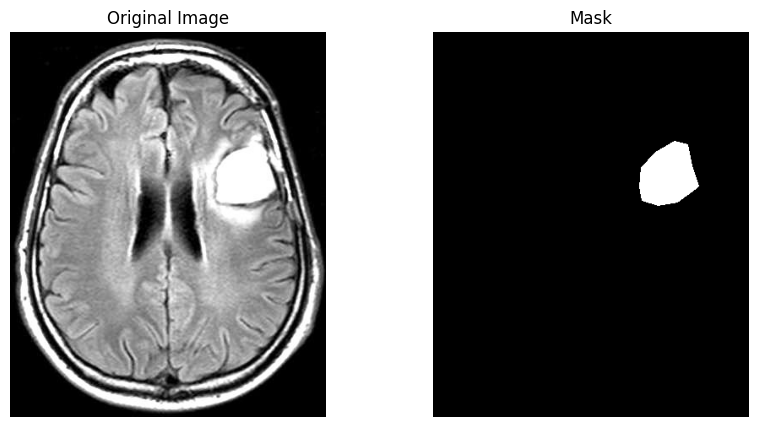

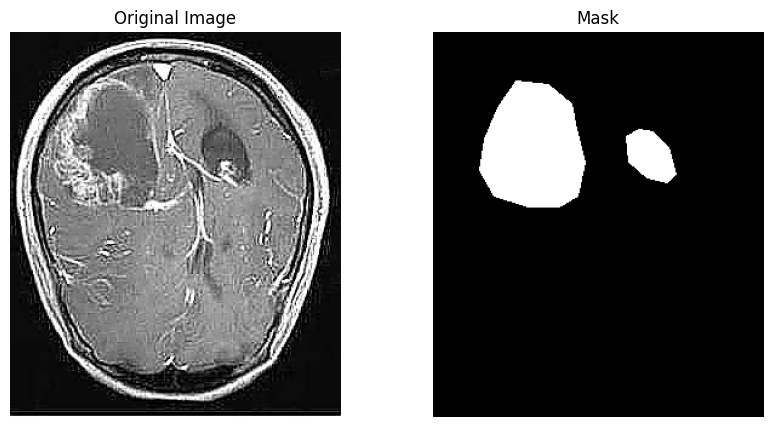

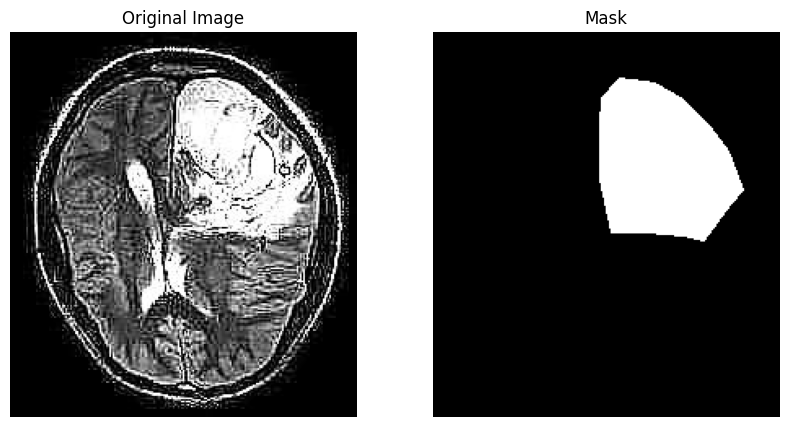

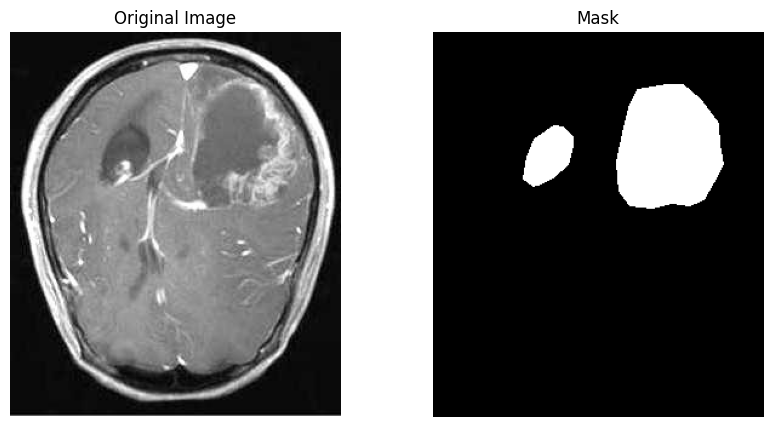

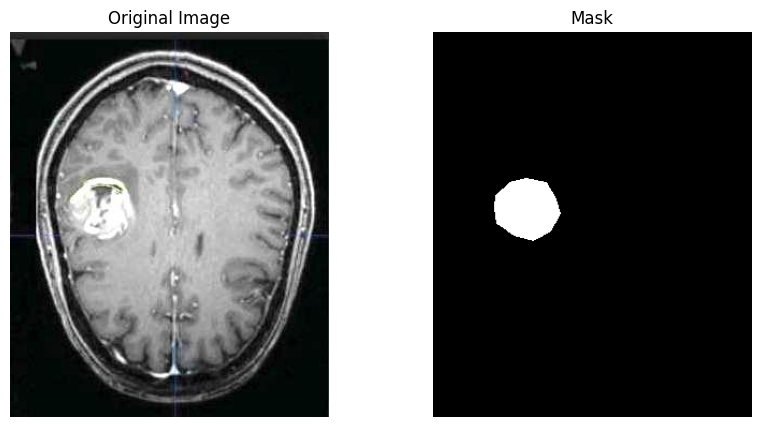

In [5]:
# Get list of all image filenames in the directory
train_image_filenames = [f for f in os.listdir(train_image_dir) if f.endswith('.jpg')]

# Randomly select 5 images
random_filenames = random.sample(train_image_filenames, 5)

# Visualize images and their masks
for image_filename in random_filenames:
    visualize_image_and_mask(train_image_dir, output_train_mask_dir, image_filename)

# Save the masks into specific folders

In [7]:
import shutil

# Zip the cropped folder
shutil.make_archive('/kaggle/working/train_masks', 'zip', '/kaggle/working/train_masks')

'/kaggle/working/train_masks.zip'

In [8]:
shutil.make_archive('/kaggle/working/val_masks', 'zip', '/kaggle/working/val_masks')

'/kaggle/working/val_masks.zip'

In [9]:
shutil.make_archive('/kaggle/working/test_masks', 'zip', '/kaggle/working/test_masks')

'/kaggle/working/test_masks.zip'